# Chest Diseases Detection
<hr>

Use Deep Learning to automate the process of detecting and classifying chest diseases in a hospital.

# Background and Business Problem

AI/ML/DL has been revolutionizing healthcare and medicine:
- Medical imagery
- Drug research
- Genome development

Deep learning has been proven to be superior in detecting and classifying disease using imagery data. Skin cancer could be detected more accurately by Deep Learning by dermatologists (2018).
- Human dermatologists detection = 86.6%
- Deep Learning detection = 95%

_Rereference: "Computer learns to detect skin cancer more accurately than doctors". The Guardian, 29 May 2018._


## Case Study

In this case study, we will assume that you work as a __Deep Learning Consultant__.
- You have been hired by a hospital in downtown Toronto and you have been tasked to automate the process of detecting and classifying chest disease and reduce the cost and time of detection.
- The team has collected extensive X-Ray Chest data and they approached you to develop a model that could detect and classify the diseases in less than 1 minute. 
- You have been provided with 133 images that belong to 4 classes:
    - Healthy
    - Covid-19
    - Bacterial Pneumonia
    - Viral Pneumonia

# Import the Libraries and Dataset

- This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray images, and normal person x-ray images. Each class contains 133 images.
- Source:
    - https://github.com/ieee8023/covid-chestxray-dataset
    - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import all the main libraries
import os
# !pip install opencv-contrib-python
import cv2 # OpenCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

# Display all the columns in pandas without being truncated
pd.options.display.max_columns = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [3]:
# Specify training data directory
# x_ray_directory = 'Datasets/Dataset'
# test_directory = 'Datasets/Test'
x_ray_directory = '/content/drive/MyDrive/ML DL/Operations Department/Datasets/Dataset'
test_directory = '/content/drive/MyDrive/ML DL/Operations Department/Datasets/Test'

# List the folder in the directory
print(os.listdir(x_ray_directory))
print(os.listdir(test_directory))

['1', '0', '2', '3']
['0', '1', '2', '3']


In [4]:
# Use the image generator to generate tensor images form 
# Use 20% of the data for cross-validation

image_generator = ImageDataGenerator( rescale=1./255, validation_split=0.2)

In [5]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

# Our training data
train_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                      batch_size=40, 
                                                      shuffle=True, 
                                                      target_size=(256,256), 
                                                      class_mode = 'categorical',
                                                      subset = 'training')

# Our validation data
validation_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                           batch_size=40, 
                                                           shuffle=True, 
                                                           target_size=(256,256), 
                                                           class_mode = 'categorical',
                                                           subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [6]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)
print(train_images.shape)
print(train_labels.shape)
print(train_labels)

(40, 256, 256, 3)
(40, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [7]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

## Visualize Dataset

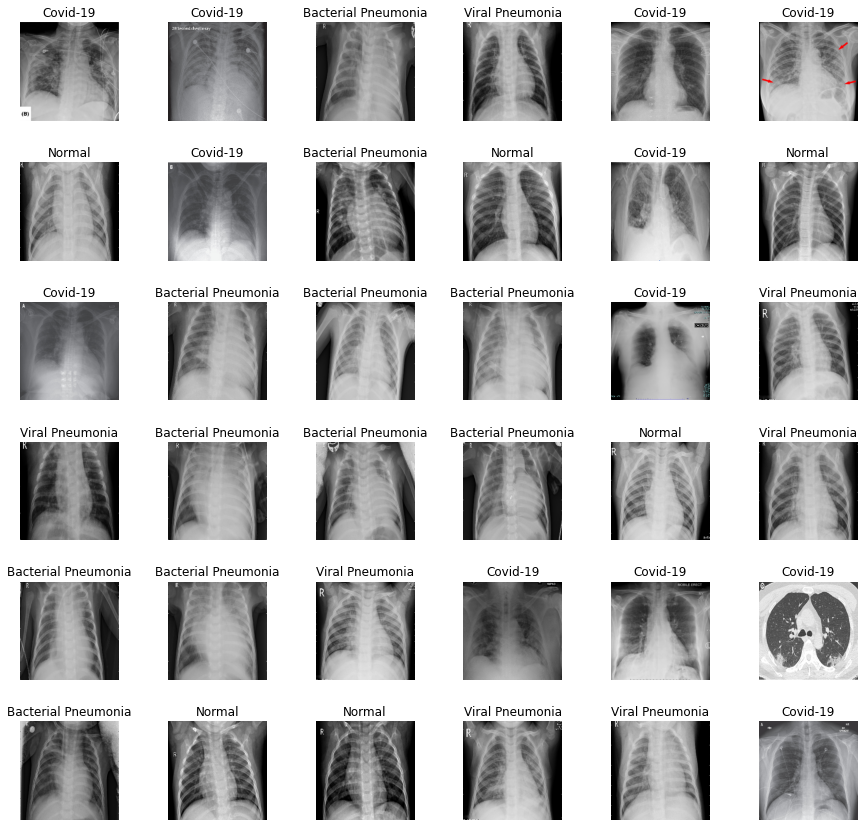

In [8]:
row = 6 
col = 6 

# create a figure and a set of subplots
fig, axes = plt.subplots(row, col, figsize = (15,15))
# flatten the axes, so that it will have 1-D array indexing from 0-35
axes = axes.ravel()

for i in np.arange(0, row*col):
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].imshow(train_images[i])
    axes[i].axis(False)

plt.subplots_adjust(wspace=0.5)

# Model Building

## Convolutional Neural Network

- The __first layers__ are used to extract high level general features.
- The __last couple of layers__ are used to perform classification (on a specific task).
- Local respective fields scan the image first searching for simple shapes such as edges/lines.
- These edges are then picked up by the subsequent layer to form more comples features.

## Deep Learning History

There are many trained off the shelve convolutional neural networks taht are readily available such as:
- LeNet-5 (1998): 7 level convolutional neural network developed by LeCun that works in classifying hand writing numbers.
- AlexNet (2012): offered massive improvement, error reduction form 26% to 15.3%.
- ZFNET (2013): achieved error of 14.8%
- Googlenet/Inception (2014): error reduction to 6.67% whihc is at par with human level accuracy.
- VGGNet (2014)
- ResNet(2015): Residual Neural Network includes 'skip connection' feature and therfore enabled training of 152 layers without vanishing gradient issues. Error of 3.57% which is superior than humans.

Source: https://medium.com/analytics-vidhya/cnns-architecture-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

## ResNet (Residual Network)

- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers which results in a very small gradient. 
- Residual Neural Network includes "skip connection" feature which enables training of 152 layers without vanishing gradient issues.
- Resnet works by adding "identity mappings" on top of the CNN.
- ImageNet contains 11 million images and 11,000 categories. 
- ImageNet is used to traing ResNet deep network.
<img src='Images/resnet.png' width='400'>

## Transfer Learning

__What is Transfer Learning?__
- Transfer learning is a machine learning technique in which a network that has been trained to perform a specific task is being reused (repurposed) as a starting point for another similar task.
- Transfer learning is widely used since starting from a pre-trained models can dramatically reduce the computational time required if training is performed from scratch.
- "Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned" - Transfer learning, Handbook of Research on Machine Learning Applications, 2009.
- In transfer learning, a base (reference) Artificial Neural Network on a base dataset and function is being trained. Then, this trained network weights are then repurposed in a second ANN to be trained on a new dataset and function.
- Transfer learning works really great if the features are general, such that trained weights can effectively repurposed. 
- Intelligence is being transferred from the base network to the newly target network.

<img src='Images/transfer-learning.png' width='800'>

__Why do We Keep the First Layer?__
- The first CNN layers are used to extract high level general features. 
- The last couple of layers are used to perform classification (on a specific task).
- So we copy the first trained layers (based model) and then we add a new custom layers in the output to perform classification on a specific new task.


## Import Model with Pretrained Weights

Let's import the ResNet50 as our base model with the followings criterion:
- use a pre-training model thas been trained on imagenet dataset;
- do not include the top fully connected layer;
- define the input tensor as our input image shape (256 x 256 x 3 ) px.

In [9]:
basemodel = ResNet50( weights='imagenet', include_top=False, input_tensor=Input( shape=(256, 256, 3)))

94781440/94765736 [==============================] - 2s 0us/step


In [10]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
# Freezing layers in the base model but keeping the last 10 layers trainable
# for layer in basemodel.layers[:-20]:
#     layer.trainable = False

# basemodel.summary()

## Build and Train the Model

In [20]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

# Define the model
model = Model( inputs = basemodel.input, outputs = headmodel)

# compilte the model
# lr = 0.001
# model.compile( optimizer=optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['acc'])
model.compile( optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), loss='categorical_crossentropy', metrics=['acc'])
# model.compile( optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
# early_stopping = EarlyStopping(monitor='val_acc', 
#                                min_delta=0, 
#                                patience=20, 
#                                verbose=1,
#                                mode='auto', 
#                                restore_best_weights=True)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with highest validation accuracy
# checkpointer = ModelCheckpoint(filepath='weights.h5', 
#                                monitor='val_acc', 
#                                save_best_only=True, 
#                                mode='max')

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="best_model.h5", verbose=1, save_best_only=True)

In [22]:
# Add our data-augmentation parameters to ImageDataGenerator
image_generator = ImageDataGenerator( rescale=1./255, validation_split=0.2)
# train_datagen = ImageDataGenerator(rescale = 1./255.,
#                                      #validation_split=0.2,
#                                      rotation_range = 40,
#                                      width_shift_range = 0.2,
#                                      height_shift_range = 0.2,
#                                      shear_range = 0.2,
#                                      zoom_range = 0.2,
#                                      horizontal_flip = True)

# test_datagen = ImageDataGenerator( rescale=1./255)

# Our training data
train_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                      batch_size=4, 
                                                      shuffle=True, 
                                                      target_size=(256,256), 
                                                      class_mode = 'categorical',
                                                      subset = 'training')

# Our validation data
validation_generator = image_generator.flow_from_directory(directory=x_ray_directory, 
                                                           batch_size=4, 
                                                           shuffle=True, 
                                                           target_size=(256,256), 
                                                           class_mode = 'categorical',
                                                           subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [23]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch= train_generator.n // 4, 
                              epochs = 200, 
                              validation_data= validation_generator, 
                              validation_steps= validation_generator.n // 4, 
                              callbacks=[checkpointer, early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
107/107 [==============================] - 364s 3s/step - loss: 0.1134 - acc: 0.9626 - val_loss: 0.4377 - val_acc: 0.8846

Epoch 00001: val_loss improved from inf to 0.43768, saving model to best_model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
107/107 [==============================] - 352s 3s/step - loss: 0.0356 - acc: 0.9907 - val_loss: 0.9092 - val_acc: 0.8173

Epoch 00002: val_loss did not improve from 0.43768
Epoch 3/200
107/107 [==============================] - 353s 3s/step - loss: 0.0080 - acc: 0.9977 - val_loss: 1.0841 - val_acc: 0.8654

Epoch 00003: val_loss did not improve from 0.43768
Epoch 4/200
107/107 [==============================] - 352s 3s/step - loss: 0.0034 - acc: 0.9977 - val_loss: 0.6721 - val_acc: 0.9038

Epoch 00004: val_loss did not improve from 0.43768
Epoch 5/200
107/107 [==============================] - 352s 3s/step - loss: 0.1154 - acc: 0.9883 - val_loss: 1.7383 - val_acc: 0.8077

Epoch 00005: val_loss did not improve from 0.43768
Epoch 6/200
107/107 [==============================] - 351s 3s/step - loss: 5.3026e-04 - acc: 1.0000 - val_loss: 1.1209 - val_acc: 0.8750

Epoch 00006: val_loss did not improve from 0.43768
Epoch 7/200
107/107 [==============================] - 351s 3s/ste

# Model Evaluation

## Visualize the Training Process

In [24]:
# Look what information we have after training 
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

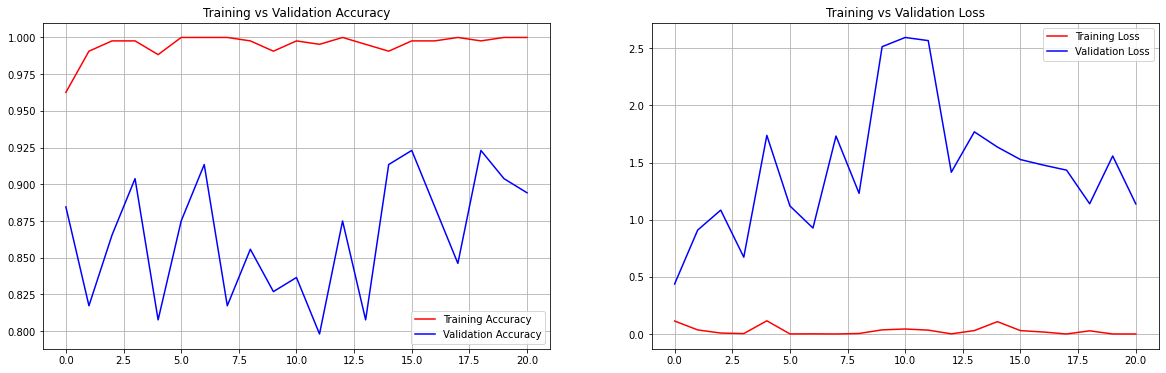

In [25]:
train_loss = history.history.get('loss')
train_acc = history.history.get('acc')
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

epochs = range(len(history.epoch))

plt.figure( figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(epochs,train_acc, 'r', label = 'Training Accuracy')
plt.plot(epochs,val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend()
# plt.show()

plt.subplot(1,2,2)
plt.plot(epochs,train_loss, 'r', label = 'Training Loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

## Evaluate the Model

Now, we will test the model using the test dataset. A very important concept here is that the testing dataset has never been seen by the model during training. Hence, this is critical.

In [26]:
saved_model = load_model('/content/best_model.h5')
test_gen = ImageDataGenerator( rescale=1./255)
test_generator = test_gen.flow_from_directory(directory=test_directory, 
                                              batch_size=10, 
                                              shuffle=True, 
                                              target_size=(256,256), 
                                              class_mode='categorical')

evaluate = saved_model.evaluate(test_generator, verbose=1)

Found 40 images belonging to 4 classes.
4/4 [==============================] - 18s 5s/step - loss: 0.8359 - acc: 0.8250


In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len( os.listdir(test_directory))):
    for item in os.listdir( os.path.join( test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        
        # normalize the image
        img = img/255
        
        image.append(img)

        # Turn the image into a 4D array (Not 3D, so we need to expand its dimension)
        # Most deep learning models expect a batch of images as input. In this case, we create a batch of one image.
        img = np.expand_dims(img, axis = 0)
        
        predict = saved_model.predict(img) 
        predict = np.argmax(predict)
        
        prediction.append(predict)
        original.append(i)

In [35]:
# Calculate the accuracy score
score = accuracy_score(original, prediction)
print("Test accuracy: {}".format(score))

Test accuracy: 0.825


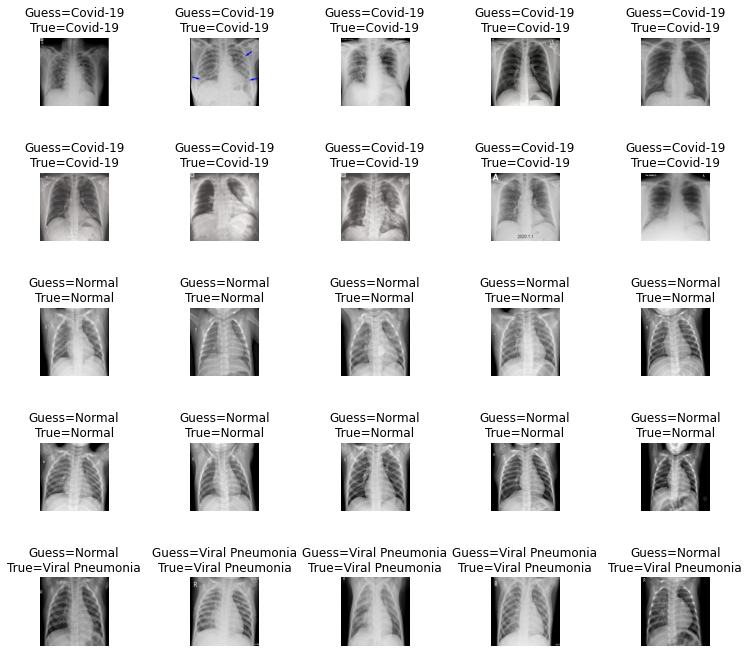

In [36]:
L = 5
W = 5

fig, axes = plt.subplots(L,W, figsize=(12,12))
axes = axes.ravel()

for i in range(L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [37]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.71      1.00      0.83        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.82        40
   macro avg       0.86      0.82      0.81        40
weighted avg       0.86      0.82      0.81        40



Text(0.5, 1.0, 'Confusion_matrix')

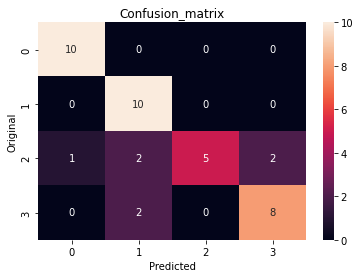

In [38]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')